<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: 3.0 Face detection model with prediction

> Authors: Pius Yee

##### In this Notebook 3.0, I will proceed with the face detection model. The face detection model will then combine with the other predictive models to detect gender, race and age.

### Import libraries

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras_vggface.vggface import VGGFace
import keras


from mtcnn import MTCNN

from IPython.display import HTML
import imageio
from moviepy.editor import VideoFileClip

---
##### Codes for Google colab -- To remove before submission

In [1]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications
!pip uninstall keras -y
!pip install keras==2.12
!pip install mtcnn


  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-v98dnj9n
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-v98dnj9n
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8294 sha256=f0b864ab1f45cbea6f049a2151459087b4163fb15bf0deb370b441cc33d515d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-q10h2dug/wheels/62/cd/e0/3a2d2fe84d014324aed54d420cab52df65a774d9b296c63996
Successfully built keras-vggface
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 635.8 kB/s eta 0:00:00
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not curren

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

## 1. Face detection model - MTCNN

##### MTCNN is a powerful tool for finding faces in images and videos. It's accurate, fast, and works well even in challenging conditions. This makes it a popular choice for tasks like facial recognition, image annotation, and emotion detection in videos.

##### In this project, I will use MTCNN to detect faces from input images/videos, and apply the predictive models.

### 1.1 Define functions and importing predictive models

##### Importing the predictive models for Gender, Race and Age from previous notebooks.

In [24]:
# Importing predictive model from previous notebooks

age_model = tf.keras.models.load_model("../models/model_age.keras")
gender_model = tf.keras.models.load_model("../models/model_gender.keras")
race_model = tf.keras.models.load_model("../models/model_race.keras")

##### I will create functions to output the result of predictive models:

In [25]:
# function for outputting the Gender Prediction Model
def predict_gender(face_image):
    gender = gender_model.predict(face_image)
    return "Male" if gender > 0.5 else "Female"

# function for outputting the Age Prediction Model
def age_class(x):
    age_classes = {'0-10': 0,'11-20': 1,'21-30': 2,'31-40': 3,'41-50': 4,'51-60': 5,'61-70': 6,'71-120': 7}

    for bucket, num in age_classes.items():
        if x == num: return bucket

# function for outputting the Race Prediction Model
def race_class(x):
    race_classes = {'Asian': 0, 'Black': 1, 'Indian': 2, 'Others': 3, 'White': 4}

    for bucket, num in race_classes.items():
        if x == num: return bucket

### 1.1 Detecting face based on `images`

##### The face detection can be done on both images and videos.

##### The following function will detect and predict faces from `images`.

In [27]:
def face_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Initialize MTCNN Detector
    detector = MTCNN()

    # Detect faces
    faces = detector.detect_faces(image)

    # Draw bounding boxes and label with predicted gender
    for face in faces:
        x, y, w, h = face['box']
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Extract the face region
        face_image = image[y:y+h, x:x+w]
        face_image = cv2.resize(face_image, (224,224))
        face_image = np.expand_dims(face_image, axis=0) / 255.0

        # Predict gender
        gender = predict_gender(face_image)

        # Predict age
        age = np.argmax(age_model.predict(face_image))

         # Predict race
        race = np.argmax(race_model.predict(face_image))

        # Overlay gender label on the image
        cv2.putText(image, f'Gender: {gender}', (x, y-70), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.putText(image, f'Age: {age_class(age)}', (x, y-40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.putText(image, f'Race: {race_class(race)}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Convert image from BGR to RGB (OpenCV uses BGR by default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with bounding boxes and gender labels inline in the notebook
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()

##### Face detection on a single face:

1/1 [==============================] - 0s 302ms/step


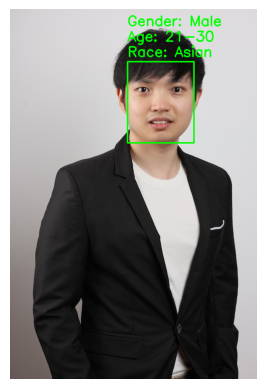

In [28]:
face_image("../datasets/pic_1.jpg")

##### It can be done on multiple faces as well:

1/1 [==============================] - 0s 13ms/step


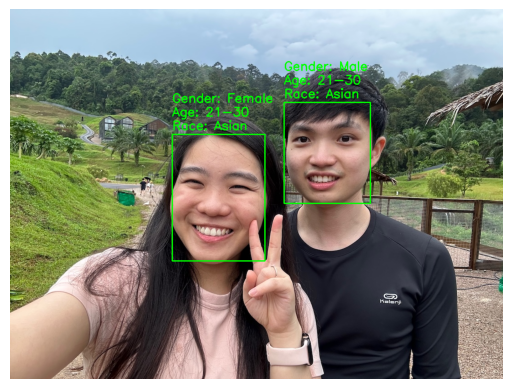

In [35]:
face_image("../datasets/pic_2.jpg")

### 1.1 Detecting face based on `videos`

I will create a function to detect and predict face from `videos`:

In [37]:
def face_video(video_path):
    cap = cv2.VideoCapture(video_path) # Initialize video capture (provide video file path)

    # Initialize MTCNN Detector
    detector = MTCNN()

    # Get video properties (for setting up the output video)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Define the output video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    out = cv2.VideoWriter(os.path.join("../output_video/",video_path.split('/')[-1]), fourcc, fps, (frame_width, frame_height))


    while True:
        ret, frame = cap.read()

        if not ret:
            break

        # Detect faces
        faces = detector.detect_faces(frame)

        # Draw bounding boxes and label with predicted gender
        for face in faces:
            x, y, w, h = face['box']
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

            # Extract the face region
            face_image = frame[y:y+h, x:x+w]
            face_image = cv2.resize(face_image, (224, 224))
            face_image = np.expand_dims(face_image, axis=0) / 255.0

            # Predict gender
            gender = predict_gender(face_image)

            # Predict age
            age = np.argmax(age_model.predict(face_image))

            # Predict race
            race = np.argmax(race_model.predict(face_image))

            # Overlay gender label on the image
            cv2.putText(frame, f'Gender: {gender}', (x, y-70), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            cv2.putText(frame, f'Age: {age_class(age)}', (x, y-40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            cv2.putText(frame, f'Race: {race_class(race)}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Write the processed frame to the output video
        out.write(frame)

    # Release resources
    cap.release()
    out.release()  # Release the output video writer

    # convert the output video to GIF so that it can be displayed here
    os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/Cellar/ffmpeg/7.0_1/bin/ffmpeg" # specify the path for ffmpeg which is one of the components needed

    videoClip = VideoFileClip(os.path.join("../output_video/",video_path.split('/')[-1]))
    videoClip.write_gif(os.path.join("../output_video/gif/",video_path.split('/')[-1]).replace('.mp4','.gif'))
    display(HTML('<img src='+os.path.join("../output_video/gif/",video_path.split('/')[-1]).replace('.mp4','.gif')+' width="300" height="500">'))


##### Face detection on a single face video.

In [38]:
# use the function to input video and output with the demographic labels
face_video("../datasets/vid_1.mp4")

1/1 [==============================] - 0s 12ms/step
MoviePy - Building file ../output_video/gif/vid_1.gif with imageio.


<img src="../output_video/gif/vid_1.gif" width="300" height="500"/>

##### Face detection on a multiple faces video.

In [39]:
# use the function to input video and output with the demographic labels
face_video("../datasets/vid_2.mp4")

1/1 [==============================] - 0s 14ms/step
MoviePy - Building file ../output_video/gif/vid_2.gif with imageio.


<img src="../output_video/gif/vid_2.gif" width="300" height="500"/>

### 1.2 Demo at an ATM camera as an ATM customer.

In [40]:
# use the function to input video and output with the demographic labels
face_video("../datasets/vid_3.mp4")

1/1 [==============================] - 0s 12ms/step
MoviePy - Building file ../output_video/gif/vid_3.gif with imageio.


<img src="../output_video/gif/vid_3.gif" width="300" height="500"/>

In [42]:
# use the function to input video and output with the demographic labels
face_video("../datasets/vid_4.mp4")

1/1 [==============================] - 0s 16ms/step
MoviePy - Building file ../output_video/gif/vid_4.gif with imageio.


<img src="../output_video/gif/vid_4.gif" width="300" height="500"/>

---
# For overall capstone project:-

### Limitation of the models:
- `Age model`: The model's performance is limited, with an accuracy of only 0.6. This is primarily due to the inherent difficulty of accurately determining age from facial features alone.  Age perception is subjective, as individuals can appear significantly older or younger than their chronological age, making it a challenging task for the model.

- `Gender and Race model`: While the model performs well in classifying gender and race, there's a potential risk of inaccurate predictions for both categories based on facial features alone. Similar to age estimation, facial appearance can differ significantly from a person's actual gender and race.

### Recommendations
- Given the limitations outlined above, banks may need to maintain additional customer data to align with the demographic appearance rather than the actual demographic in the customer profile. For instance, if a 30-year-old customer appears to be 20 years old, the system should be capable of recognizing them as having an appearance age of 20 years old after several detections. This approach would address the issue of appearance not matching the customer's actual profile.

### Conclusion

- The models effectively tackle the problem statement by enhancing ATM security. They assist in identifying suspicious cash withdrawals through face detection, where the individual withdrawing cash does not match the cardholder's profile. This introduces an additional layer of security for ATM customers, instilling greater trust and confidence in the bank's ATM services.